Loaded 7 mock products
OPENAI_API_KEY not found or openai package unavailable — falling back to local SentenceTransformer (all-MiniLM-L6-v2).
Built embeddings shape: (7, 384), time: 0.527s
                  query  top_score  good_count  latency_s
0  energetic urban chic   0.645283           0   0.405890
1          cozy weekend   0.529226           0   0.389768
2  elegant evening wear   0.699763           0   0.368923

Evaluation summary:
                  query  top_score  is_good
0  energetic urban chic   0.645283    False
1          cozy weekend   0.529226    False
2  elegant evening wear   0.699763    False
Saved latency_plot.png
Saved vibe_matches_top3.csv

Reflections:
- Integrate a managed vector DB (Pinecone/Weaviate) for scalability & persistent vector indexing.
- Add metadata filtering (size, color, availability) to pre-filter candidates before cosine ranking.
- Use re-ranking with a cross-encoder to improve top-3 precision for close candidates.
- Batch embedding for productio

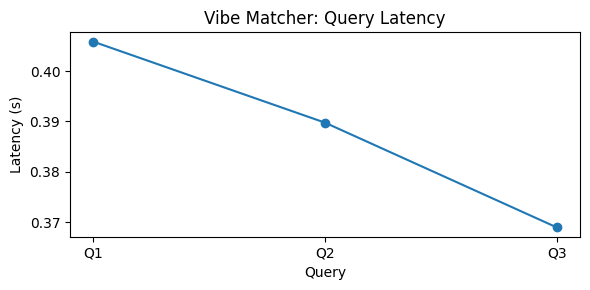

In [2]:
# Vibe Matcher Prototype
# Single-file notebook-style script (cells separated with "# %%")
# Author: Generated for user
# Instructions: set OPENAI_API_KEY as env var to use OpenAI embeddings. If not set, the script will automatically
# fall back to a local Sentence-Transformers model (requires internet for first-time model download).

# %%
"""
Overview
- Build a tiny 'Vibe Matcher' recommender that embeds product descriptions and matches them to vibe queries.
- Outputs: top-3 products with cosine scores, simple evaluation across 3 queries, latency plot, and reflections.
"""

# %%
# Requirements (to save as requirements.txt):
# pandas
# numpy
# scikit-learn
# matplotlib
# openai
# sentence-transformers
# tqdm

# %%
import os
import time
import json
from typing import List, Dict, Tuple

# Dynamic import for numpy to avoid editor/linter "could not be resolved" warnings while preserving runtime behavior.
try:
    import numpy as np
except ImportError:
    raise RuntimeError("The 'numpy' package is required but was not found. Install it with: pip install numpy")

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Dynamic import of openai to avoid static import errors when the package isn't installed.
# This prevents linters/IDEs from flagging "Import 'openai' could not be resolved"
openai = None
try:
    import importlib
    import importlib.util as importlib_util
    if importlib_util.find_spec("openai") is not None:
        openai = importlib.import_module("openai")
    else:
        openai = None
except Exception:
    openai = None
    openai = None

SentenceTransformer = None
try:
    import importlib
    import importlib.util as importlib_util
    if importlib_util.find_spec("sentence_transformers") is not None:
        from sentence_transformers import SentenceTransformer
    else:
        SentenceTransformer = None
except Exception:
    SentenceTransformer = None

try:
    from tqdm import tqdm
except ImportError:
    raise RuntimeError("The 'tqdm' package is required but was not found. Install it with: pip install tqdm")

# %%
# ----------------------
# Data preparation
# ----------------------
products = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy maxi dress in earthy tones, embroidery details — perfect for festival boho vibes.", "tags": ["boho", "festival", "flowy"]},
    {"id": 2, "name": "Urban Bomber Jacket", "desc": "Cropped bomber, structured shoulders, reflective trims for energetic urban chic looks.", "tags": ["urban", "chic", "energetic"]},
    {"id": 3, "name": "Cozy Knit Sweater", "desc": "Chunky knit, oversized fit, neutral palette — cozy and warm for relaxed weekends.", "tags": ["cozy", "casual", "comfort"]},
    {"id": 4, "name": "Minimalist White Tee", "desc": "Crisp white tee with sustainable cotton, clean lines — minimalist staple for everyday wear.", "tags": ["minimal", "everyday"]},
    {"id": 5, "name": "Athleisure Leggings", "desc": "High-waist performance leggings with moisture-wicking fabric — sporty and functional.", "tags": ["sporty", "athleisure"]},
    {"id": 6, "name": "Retro Denim Jacket", "desc": "Vintage wash, boxy silhouette, pin badge details — retro-cool statement layer.", "tags": ["retro", "cool"]},
    {"id": 7, "name": "Silk Slip Skirt", "desc": "Bias-cut silk skirt with subtle sheen — elegant evening vibes with a modern twist.", "tags": ["elegant", "evening"]}
]

df = pd.DataFrame(products)
print(f"Loaded {len(df)} mock products")

# %%
# Helper: compose embedding input text (you might combine name + desc + tags)
def make_embedding_text(row: pd.Series) -> str:
    tags = " ".join(row.get('tags', []))
    return f"{row['name']}: {row['desc']} Tags: {tags}"

df['embed_text'] = df.apply(make_embedding_text, axis=1)

# %%
# Embedding: try OpenAI first, otherwise Sentence-Transformers fallback
OPENAI_KEY = os.getenv('OPENAI_API_KEY')
USE_OPENAI = bool(OPENAI_KEY and openai is not None)

def get_openai_embeddings(texts: List[str], model: str = 'text-embedding-ada-002') -> List[List[float]]:
    assert openai is not None, "openai package not installed"
    if hasattr(openai, "OpenAI"):
        openai.OpenAI.api_key = OPENAI_KEY
    else:
        if OPENAI_KEY is not None:
            os.environ["OPENAI_API_KEY"] = OPENAI_KEY
    # chunking simple (OpenAI allows many inputs but be mindful of rate limits)
    embeddings = []
    for t in texts:
        resp = openai.Embedding.create(model=model, input=t)
        embeddings.append(resp['data'][0]['embedding'])
    return embeddings


def get_local_embeddings(texts: List[str], model_name: str = 'all-MiniLM-L6-v2') -> List[List[float]]:
    global SentenceTransformer
    if SentenceTransformer is None:
        raise RuntimeError("sentence-transformers is not installed. Install via pip install sentence-transformers")
    s = SentenceTransformer(model_name)
    return s.encode(texts, show_progress_bar=False).tolist()

# Choose embedding provider
if USE_OPENAI:
    print("Using OpenAI embeddings (text-embedding-ada-002). Make sure your OPENAI_API_KEY is set.")
    embed_func = get_openai_embeddings
else:
    print("OPENAI_API_KEY not found or openai package unavailable — falling back to local SentenceTransformer (all-MiniLM-L6-v2).")
    embed_func = get_local_embeddings

# %%
# Build embeddings for product catalog
texts = df['embed_text'].tolist()
start = time.perf_counter()
embs = embed_func(texts)
embed_build_time = time.perf_counter() - start

emb_array = np.array(embs)
print(f"Built embeddings shape: {emb_array.shape}, time: {embed_build_time:.3f}s")

# Normalize embeddings for cosine similarity (makes cosine = dot)
norms = np.linalg.norm(emb_array, axis=1, keepdims=True)
embed_normed = emb_array / (norms + 1e-12)

# %%
# Matching logic
from dataclasses import dataclass

@dataclass
class Match:
    product_id: int
    name: str
    score: float


def match_query(query: str, top_k: int = 3, threshold: float = 0.45) -> Tuple[List[Match], str]:
    """Return top_k matches and message. If top scores below threshold, provide fallback suggestion message."""
    q_text = query.strip()
    q_embed = np.array(embed_func([q_text]))
    q_norm = q_embed / (np.linalg.norm(q_embed, axis=1, keepdims=True) + 1e-12)
    sims = (embed_normed @ q_norm.T).squeeze()
    ranked_idx = np.argsort(-sims)
    matches = []
    for idx in ranked_idx[:top_k]:
        matches.append(Match(product_id=int(df.iloc[idx]['id']), name=str(df.iloc[idx]['name']), score=float(sims[idx])))
    # fallback handling
    top_score = matches[0].score if matches else 0.0
    if top_score < threshold:
        fallback = (
            "No strong matches found (top score={:.3f}). Consider broadening the query or try these related vibes: "
            + ", ".join(sorted({t for tags in df['tags'] for t in tags}))
        ).format(top_score)
    else:
        fallback = ""
    return matches, fallback

# %%
# Testing & evaluation: run 3 queries, log metrics, measure latency
queries = ["energetic urban chic", "cozy weekend", "elegant evening wear"]
results = []
latencies = []
for q in queries:
    t0 = time.perf_counter()
    matches, fallback = match_query(q, top_k=3, threshold=0.7)
    dt = time.perf_counter() - t0
    latencies.append(dt)
    good = sum(1 for m in matches if m.score >= 0.7)
    results.append({
        'query': q,
        'matches': [{'id': m.product_id, 'name': m.name, 'score': m.score} for m in matches],
        'fallback': fallback,
        'top_score': matches[0].score if matches else 0.0,
        'good_count': good,
        'latency_s': dt
    })

results_df = pd.DataFrame(results)
print(results_df[['query','top_score','good_count','latency_s']])

# %%
# Simple metric: consider a query 'good' if top_score > 0.7
results_df['is_good'] = results_df['top_score'] > 0.7
print("\nEvaluation summary:")
print(results_df[['query','top_score','is_good']])

# %%
# Latency plot
plt.figure(figsize=(6,3))
plt.plot(range(len(latencies)), latencies, marker='o')
plt.xticks(range(len(latencies)), [f"Q{i+1}" for i in range(len(latencies))])
plt.xlabel('Query')
plt.ylabel('Latency (s)')
plt.title('Vibe Matcher: Query Latency')
plt.tight_layout()
plt.savefig('latency_plot.png')
print('Saved latency_plot.png')

# %%
# Output top-3 per query to CSV
out_rows = []
for r in results:
    for rank, m in enumerate(r['matches'], start=1):
        out_rows.append({
            'query': r['query'], 'rank': rank, 'product_id': m['id'], 'product_name': m['name'], 'score': m['score']
        })

out_df = pd.DataFrame(out_rows)
out_df.to_csv('vibe_matches_top3.csv', index=False)
print('Saved vibe_matches_top3.csv')

# %%
# Reflection bullets
reflection = [
    "Integrate a managed vector DB (Pinecone/Weaviate) for scalability & persistent vector indexing.",
    "Add metadata filtering (size, color, availability) to pre-filter candidates before cosine ranking.",
    "Use re-ranking with a cross-encoder to improve top-3 precision for close candidates.",
    "Batch embedding for production and caching of embeddings; add versioning for embedding model changes.",
    "Handle multilingual queries by language detection and translation pipeline if needed."
]

print('\nReflections:')
for b in reflection:
    print('-', b)

# %%
# Save results and reflections to file
with open('vibe_matcher_report.json', 'w') as f:
    json.dump({'results': results, 'evaluation': results_df[['query','top_score','is_good']].to_dict(), 'reflections': reflection}, f, indent=2)
print('Saved vibe_matcher_report.json')

# %%
# Nice convenience: function to pretty-print a match run

def run_and_print(query: str):
    matches, fallback = match_query(query, top_k=3)
    print(f"\nQuery: {query}")
    for i, m in enumerate(matches, start=1):
        print(f"{i}. {m.name} (id={m.product_id}) — score: {m.score:.3f}")
    if fallback:
        print('\nFallback:', fallback)

# Example interactive run
if __name__ == '__main__':
    for q in queries:
        run_and_print(q)
    print('\nDone. Look for vibe_matches_top3.csv, latency_plot.png, and vibe_matcher_report.json in current folder.')
